In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Plot Analysis

## 1 Color the Scatter Plots Based on a Variable (BIOME_NAME)

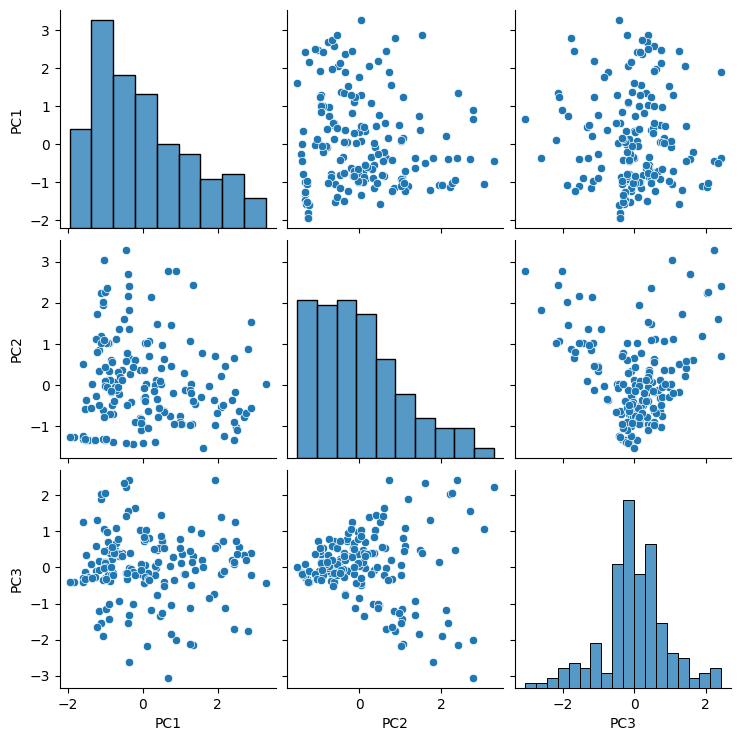

In [20]:
# Load PCA results
pca_df = pd.read_csv('./outputs/csv/pca_reduced_data.csv')

# Pairplot with color coding based on ecoregion type
sns.pairplot(pca_df[["PC1", "PC2", "PC3"]])
plt.show()

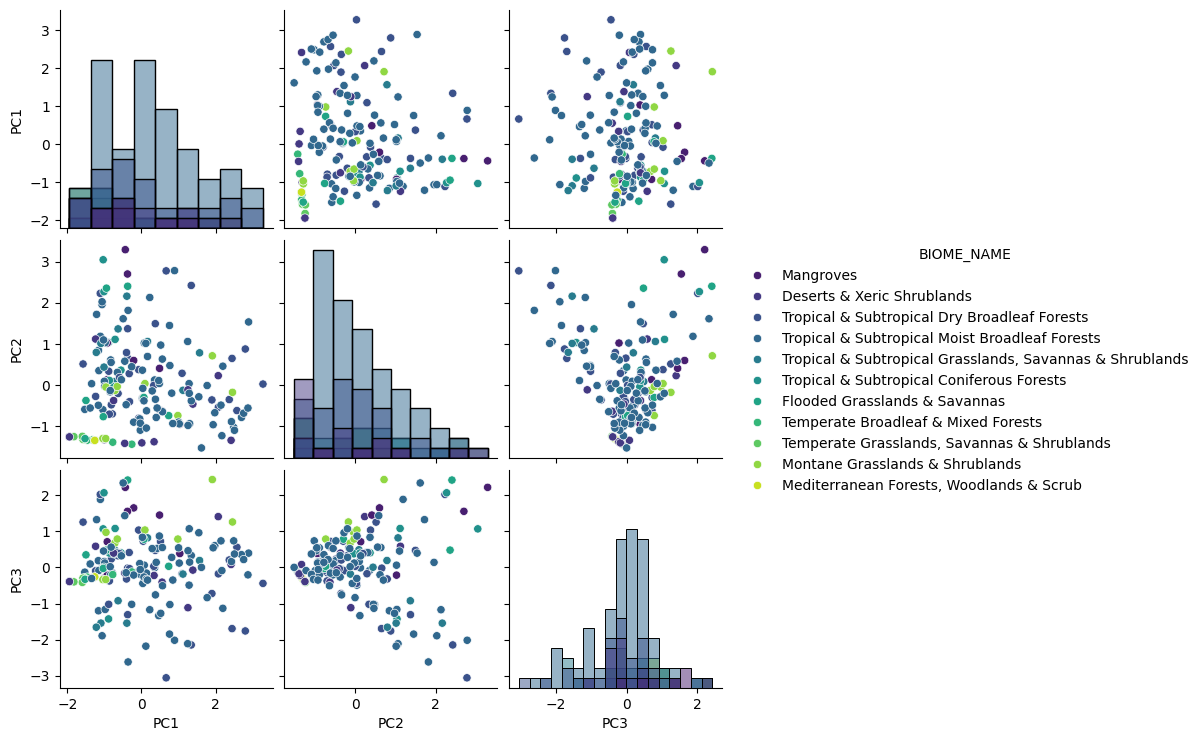

In [21]:
# Load PCA results
pca_df = pd.read_csv('./outputs/csv/pca_reduced_data.csv')
# If you have a categorical variable (e.g., ecoregion type), add it to the PCA DataFrame
ecoregions_gdf = gpd.read_file("outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg", layer="zonal_statistics_v2")
pca_df["BIOME_NAME"] = ecoregions_gdf["BIOME_NAME"]  # Replace with actual categorical column

# Pairplot with color coding based on ecoregion type
sns.pairplot(pca_df, hue="BIOME_NAME", diag_kind="hist", palette="viridis")
plt.show()

## 2. Apply Clustering (K-Means) on PCA Data

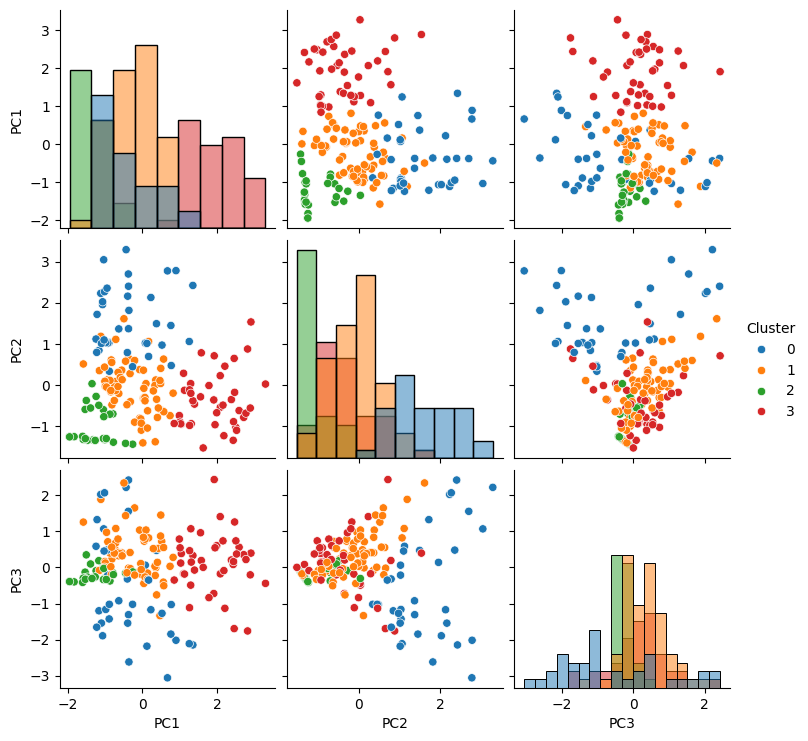

In [22]:
# # pairplot visualization
# sns.pairplot(pca_df)
# plt.show()
# Set the number of clusters (e.g., 3 clusters)
num_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
pca_df["Cluster"] = kmeans.fit_predict(pca_df[["PC1", "PC2", "PC3"]])
pca_df.to_csv("outputs/csv/pca_reduced_data.csv", index=False)

# Scatter plot of PCA clusters
sns.pairplot(pca_df, hue="Cluster", diag_kind="hist", palette="tab10")
plt.show()

## 3. 3D Visualization of PCA-Transformed Data

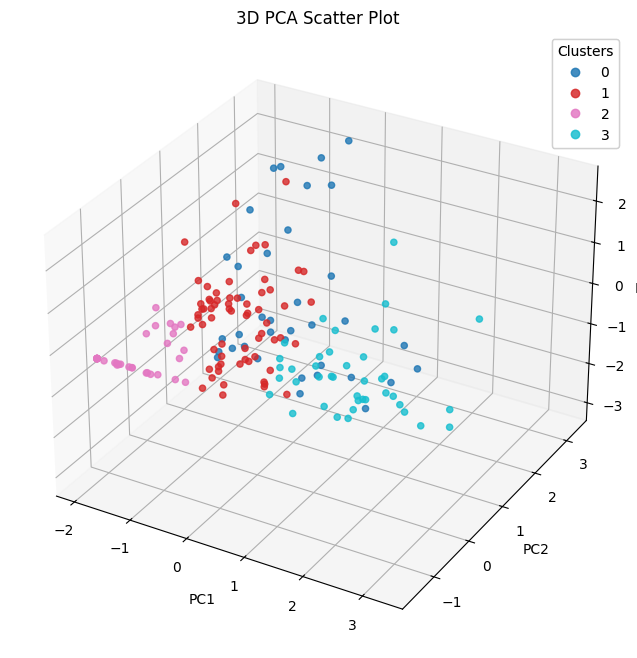

In [23]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with cluster colors
scatter = ax.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=pca_df["Cluster"], cmap="tab10", alpha=0.8)

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Scatter Plot")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

# Evaluating and Refining Clustering

1️⃣ Evaluating Clustering Quality with Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for K-Means clustering
silhouette_avg = silhouette_score(pca_df[["PC1", "PC2", "PC3"]], pca_df["Cluster"])
print(f"Silhouette Score for K-Means: {silhouette_avg:.3f}")


2️⃣ Try Hierarchical Clustering (Agglomerative Clustering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Compute the linkage matrix for a dendrogram
linked = sch.linkage(pca_df[["PC1", "PC2", "PC3"]], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linked)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

Assign Cluster Labels

In [ ]:
# Apply Agglomerative Clustering with 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=3)
pca_df["Agg_Cluster"] = agg_clustering.fit_predict(pca_df[["PC1", "PC2", "PC3"]])

# Plot clusters
sns.pairplot(pca_df, hue="Agg_Cluster", diag_kind="hist", palette="tab10")
plt.show()

3️⃣ Apply DBSCAN for Density-Based Clustering

In [ ]:

from sklearn.cluster import DBSCAN

# Apply DBSCAN (eps controls the neighborhood radius, min_samples is the minimum cluster size)
dbscan = DBSCAN(eps=0.8, min_samples=5)
pca_df["DBSCAN_Cluster"] = dbscan.fit_predict(pca_df[["PC1", "PC2", "PC3"]])

# Plot DBSCAN clusters
sns.pairplot(pca_df, hue="DBSCAN_Cluster", diag_kind="hist", palette="tab10")
plt.show()

# 🌍 Visualizing Clusters on a Geographic Map

1️⃣ Merge Clusters with Geographic Data

In [ ]:
import geopandas as gpd
import pandas as pd

# Load original GeoPackage data
path_gpkg = "outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg"
layer_name = "zonal_statistics_v2"
ecoregions_gdf = gpd.read_file(path_gpkg, layer=layer_name)

# # Load PCA results
# pca_df = pd.read_csv("outputs/csv/pca_reduced_data.csv")

# Ensure both datasets are aligned (index match or common key)
pca_df["geometry"] = ecoregions_gdf["geometry"]  # Attach geometry column
gdf_clusters = gpd.GeoDataFrame(pca_df, geometry="geometry")
print(gdf_clusters.columns)

# Save the updated GeoDataFrame
gdf_clusters.to_file("outputs/geopackages/clustered_ecoregions.gpkg", layer="clusters", driver="GPKG")
print("Clustered data saved to GeoPackage ✅")


2️⃣ Create an Interactive Folium Map

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Load clustered geospatial data
gdf_clusters = gpd.read_file("outputs/geopackages/clustered_ecoregions.gpkg", layer="clusters")

# Ensure geometries are Points (convert Polygons to centroids)
gdf_clusters["geometry"] = gdf_clusters["geometry"].centroid

# Get map center
map_center = [gdf_clusters.geometry.y.mean(), gdf_clusters.geometry.x.mean()]

# Create Folium Map
m = folium.Map(location=map_center, zoom_start=5, tiles="cartodb positron")

# Define cluster colors
cluster_colors = {0: "red", 1: "blue", 2: "green", 3: "purple", -1: "black"}  # -1 for DBSCAN outliers

# Add markers to the map
marker_cluster = MarkerCluster().add_to(m)

for _, row in gdf_clusters.iterrows():
    cluster_label = row["Cluster"]  # Change to "Agg_Cluster" or "DBSCAN_Cluster" if needed
    color = cluster_colors.get(cluster_label, "gray")  # Default to gray if not in dict
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Ecoregion Cluster: {cluster_label}"
    ).add_to(marker_cluster)

# Save and display map
map_file = "outputs/clustered_ecoregions_map.html"
m.save(map_file)
print(f"Map saved as {map_file} ✅")


In [ ]:
gdf_clusters.dtypes

In [ ]:
print(gdf_clusters.columns)


In [16]:
import plotly.express as px
import pandas as pd

# Load PCA-transformed data
pca_df = pd.read_csv("outputs/csv/pca_reduced_data.csv")

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df[["PC1", "PC2", "PC3", "Cluster"]], 
    x="PC1", 
    y="PC2", 
    z="PC3", 
    color="Cluster",  # Color by cluster
    title="Interactive 3D PCA Scatter Plot",
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
    opacity=0.8
)

# Show interactive plot
fig.show()
